In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, TimeDistributed, Activation
from tensorflow.keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten,BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Convolution2D,Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
from keras import optimizers
from tensorflow.keras import backend as K
import snnlib


In [ ]:
datasetFolderName='DS2'
MODEL_FILENAME="imageClassificationModel.h5"
img_rows, img_cols, numOfChannels =  100, 100, 1
train_path=datasetFolderName+'/train/'
validation_path=datasetFolderName+'/val/'
test_path=datasetFolderName+'/test/'

## Model configuration
batch_size = 8
epoch=20
lossfn = "mse"
# Length of time (in seconds) represented by one time step. Defaults to 0.001s.

snnlib.timeconfig.length = 2

In [ ]:
def showResults(test, pred):
    target_names = ['positive', 'negative']
    print(classification_report(test, pred, target_names=target_names))
    accuracy = accuracy_score(test, pred)
    precision=precision_score(test, pred, average='weighted')
    f1Score=f1_score(test, pred, average='weighted') 
    print("Accuracy  : {}".format(accuracy))
    print("Precision : {}".format(precision))
    print("f1Score : {}".format(f1Score))
    cm=confusion_matrix(test, pred)
    print(cm)
    
def f1_m(y_true, y_pred):
    precision = precision_m(y_true, y_pred)
    recall = recall_m(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def recall_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def precision_m(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [ ]:
train_datagen = ImageDataGenerator(
                rescale=1./255,
            	fill_mode="nearest"
                )
validation_datagen = ImageDataGenerator(
                rescale=1./255,
            	fill_mode="nearest"
                )
test_datagen = ImageDataGenerator(rescale=1./255)



train_generator = train_datagen.flow_from_directory(
        train_path,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode="grayscale")

validation_generator = train_datagen.flow_from_directory(
        validation_path,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        class_mode='categorical',
        color_mode="grayscale")

test_generator = test_datagen.flow_from_directory(
        test_path,
        target_size=(img_rows, img_cols),
        batch_size=batch_size,
        color_mode="grayscale",
        class_mode=None,
        shuffle=False)

In [ ]:
def getSpikeModel():
    model = Sequential()
    
    model.add(Conv2D(100, kernel_size = (5, 5), input_shape=(img_rows, img_cols, numOfChannels)))
    model.add(snnlib.SNNActivation("relu", snntraining=True))
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(50, kernel_size=(3,3)))
    model.add(snnlib.SNNActivation("relu", snntraining=True))
    
    model.add(MaxPooling2D(pool_size=(2,2)))
    model.add(Conv2D(50, kernel_size=(3,3)))
    model.add(snnlib.SNNActivation("relu", snntraining=True))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(100, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(2, activation = 'softmax'))
    model.compile(optimizer='adam', loss=lossfn, metrics=['accuracy', f1_m])
    
    return model

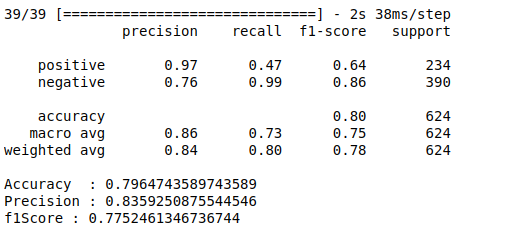

In [ ]:
def getTradModel():
    model = Sequential()
    
    model.add(Conv2D(100, kernel_size = (5, 5), input_shape=(img_rows, img_cols, numOfChannels)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))

    model.add(Conv2D(50, kernel_size=(3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Conv2D(50, kernel_size=(3,3)))
    model.add(Activation("relu"))
    model.add(MaxPooling2D(pool_size=(2,2)))
    
    model.add(Flatten())
    model.add(Dense(100, activation="relu"))
    model.add(Dense(50, activation="relu"))
    model.add(Dense(2, activation = 'softmax'))
    model.compile(optimizer='adam', loss=lossfn, metrics=['accuracy',f1_m])
    
    return model

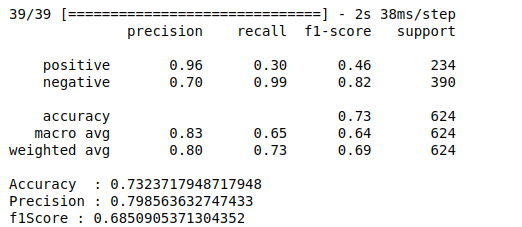

In [ ]:
# Select getTradModel for the traditional model, or select getSpikeModel() for the spike model
model = getSpikeModel()

In [ ]:
checkpoint = ModelCheckpoint(MODEL_FILENAME, 
                             monitor='loss',
                             verbose=1, 
                             save_best_only= True, 
                             mode='min') 
early_stopping = EarlyStopping(monitor='loss',
                               patience=5,
                               verbose=1,
                               mode='min')


model.fit(train_generator,
                            epochs=epoch,
                            validation_data=validation_generator, 
                            callbacks=[checkpoint, early_stopping])

In [ ]:
# Testing/Prediction phase
predictions = model.predict(test_generator, verbose=1)
yPredictions = np.argmax(predictions, axis=1)
true_classes = test_generator.classes
# Display the performance of the model on test data
showResults(true_classes[:len(yPredictions)], yPredictions)